**Imports & Configuration**

All libraries and visualization settings for the project.

In [ ]:
import os
import ast
import textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Scikit-Learn (Preprocessing & Model Selection)
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (mean_squared_error, r2_score, classification_report, 
                             roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay)

# TensorFlow / Keras
import importlib.util
# If TensorFlow is not installed in the current environment, install it via pip magic.
if importlib.util.find_spec("tensorflow") is None:
    # Install TensorFlow in the notebook environment
    %pip install tensorflow
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Matplotlib Configuration for cooler plots
plt.rcParams.update({
    'figure.figsize': (12, 6),
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
})

# Visualization Constants
BAR_OPACITY = 0.8
GRID_STYLE = {'which': 'major', 'axis': 'y', 'linestyle': '--', 'linewidth': 0.4}

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

**Aux Functions (Visualization)**

Defined early so they are available for all EDA steps.

In [3]:
# Function to wrap x-axis labels for better readability
def wrap_labels(ax, width=15, **kw):
    labels = [textwrap.fill(label.get_text(), width) for label in ax.get_xticklabels()]
    ax.set_xticks(ax.get_xticks())  # Ensure ticks are set
    ax.set_xticklabels(labels, ha='center', fontdict={'size': 8}, **kw)

# Function to plot bar charts with common settings
def plot_bar(series, title, xlabel, ylabel, fmt='{:.1f}', ylim=None):
    fig, ax = plt.subplots()
    bars = ax.bar(series.index, series.values, alpha=BAR_OPACITY)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(**GRID_STYLE)
    
    if ylim:
        ax.set_ylim(ylim)
        
    wrap_labels(ax)
    
    # Coloring
    for bar, color in zip(bars, plt.cm.tab10.colors):
        bar.set_color(color)
        
    # Add bar labels if format is specified
    if fmt:
        ax.bar_label(bars, fmt=fmt, padding=2)
    
    plt.tight_layout()
    plt.show()

# Function to parse list columns safely
def parse_list_column(x):
    if isinstance(x, list): return x
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return []

**Data Loading & Cleaning Pipeline**

Loads raw data, cleans currencies, handles strings, and creates the clean DataFrame df.

In [4]:
# Path to the CSV file
csv_path = 'IMDb Movies.csv'

if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV file not found at {csv_path}")

# Load Raw Data
df = pd.read_csv(csv_path, low_memory=False)

# 1. Rename columns
df = df.drop(columns=['title']) 
df = df.rename(columns={
    'original_title': 'title',
    'imdb_title_id': 'id',
    'date_published': 'release_date',
    'avg_vote': 'imdb_score',
    'worlwide_gross_income': 'world_wide_boxoffice'
})

# 2. Filter valid years
df = df[df['year'].astype(str).str.match(r'^\d{4}$')]
df['year'] = df['year'].astype(int)

# 3. Column Type Transformations
df['id'] = df['id'].str.replace(r'^tt', '', regex=True).astype(int)
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_month'] = df['release_date'].dt.month.astype('Int8')
df['duration'] = pd.to_numeric(df['duration'], errors='coerce').astype('Int16')
df['imdb_score'] = pd.to_numeric(df['imdb_score'], errors='coerce').astype('float32')
df['votes'] = pd.to_numeric(df['votes'], errors='coerce').astype('Int32')
df['metascore'] = pd.to_numeric(df['metascore'], errors='coerce').astype('Int16')

# 4. Clean Financial Columns
for col in ['budget', 'world_wide_boxoffice']:
    df[col] = df[col].replace(r'[\$,]', '', regex=True)
    df[col] = pd.to_numeric(df[col], errors='coerce').astype('float64')

# 5. Parse Text Fields
def split_first(x):
    if pd.isna(x): return pd.NA
    return x.split(',')[0].strip().title()

def split_list(x, n):
    if pd.isna(x): return []
    return [item.strip().title() for item in x.split(',')][:n]

# Apply parsing
df['genres'] = df['genre'].map(lambda x: [] if pd.isna(x) else [g.strip().title() for g in x.split(',')])
df['country'] = df['country'].map(split_first)
df['language'] = df['language'].map(split_first)
df['production_company'] = df['production_company'].map(split_first)
df['directors'] = df['director'].map(lambda x: split_list(x, 2))
df['writers'] = df['writer'].map(lambda x: split_list(x, 3))
df['actors'] = df['actors'].map(lambda x: split_list(x, 5))

# 6. Treat Missing Values
df.loc[df['budget'] == 0, 'budget'] = pd.NA
df.loc[df['world_wide_boxoffice'] == 0, 'world_wide_boxoffice'] = pd.NA

# Drop rows with insufficient data
df = df.dropna(subset=['imdb_score', 'votes', 'metascore'])
df = df[df['votes'] >= 50]  

# 7. Feature Engineering
df['profit'] = df['world_wide_boxoffice'] - df['budget']
df['profit_margin'] = df['profit'] / df['budget']

# 8. Rounding & Final Formatting
df['imdb_score'] = df['imdb_score'].round(1)
df['profit_margin'] = df['profit_margin'].round(2)
df['budget'] = df['budget'].round(0).astype('Int64')
df['world_wide_boxoffice'] = df['world_wide_boxoffice'].round(0).astype('Int64')
df['profit'] = df['profit'].round(0).astype('Int64')

# Select Final Columns
final_cols = [
    'id','title','year','release_month','genres','duration',
    'country','language','directors','writers','actors','production_company',
    'imdb_score','votes','budget','world_wide_boxoffice',
    'metascore','profit','profit_margin', 'release_date'
]
df = df[final_cols]

# Save processed file (Optional checkpoint)
# df.to_csv('IMDb_Movies_Updated.csv', index=False)

print("Data Cleaning Complete.")
df.info()

Data Cleaning Complete.
<class 'pandas.core.frame.DataFrame'>
Index: 13304 entries, 76 to 85839
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    13304 non-null  int64         
 1   title                 13304 non-null  object        
 2   year                  13304 non-null  int64         
 3   release_month         13219 non-null  Int8          
 4   genres                13304 non-null  object        
 5   duration              13304 non-null  Int16         
 6   country               13299 non-null  object        
 7   language              13270 non-null  object        
 8   directors             13304 non-null  object        
 9   writers               13304 non-null  object        
 10  actors                13304 non-null  object        
 11  production_company    13177 non-null  object        
 12  imdb_score            13304 non-null  float32       
 

**Basic EDA (Top 10s)**

Using the clean df directly.

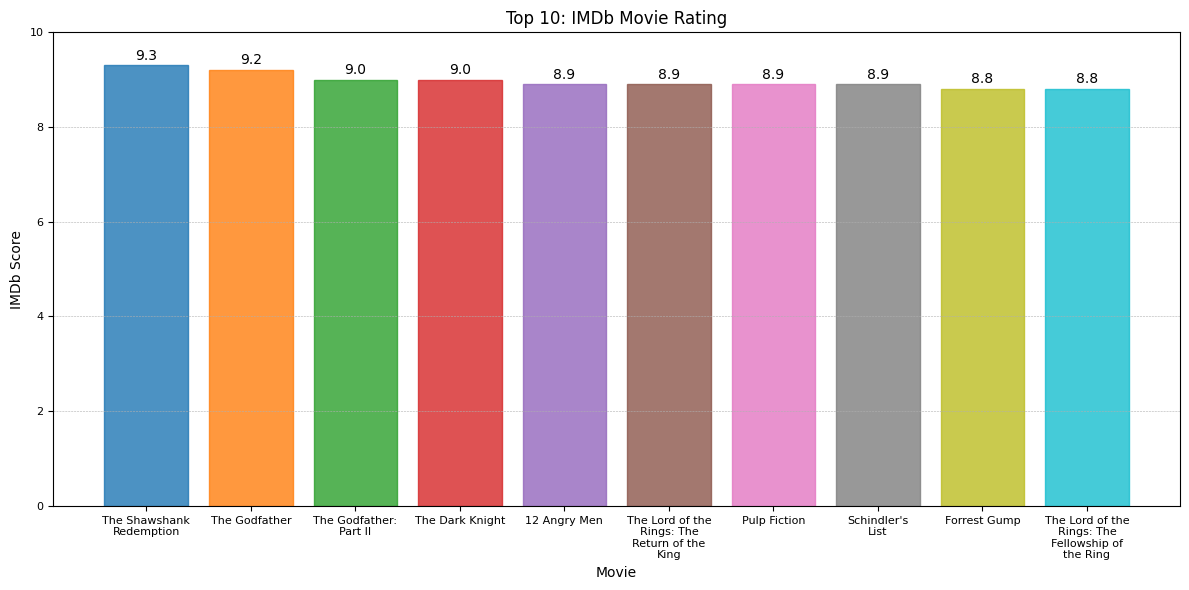

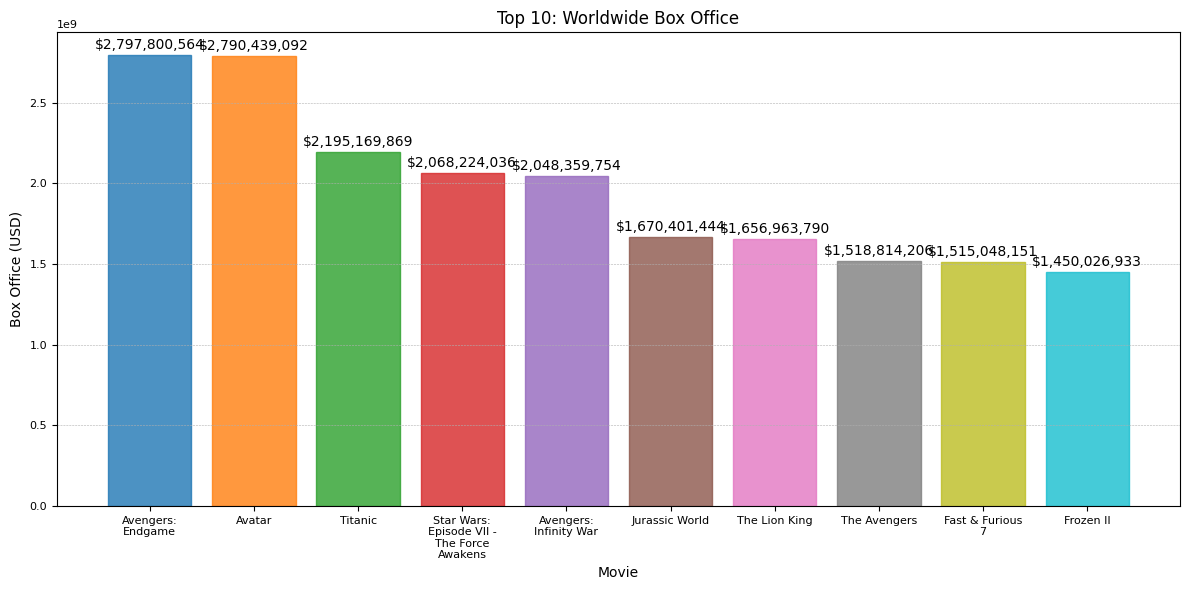

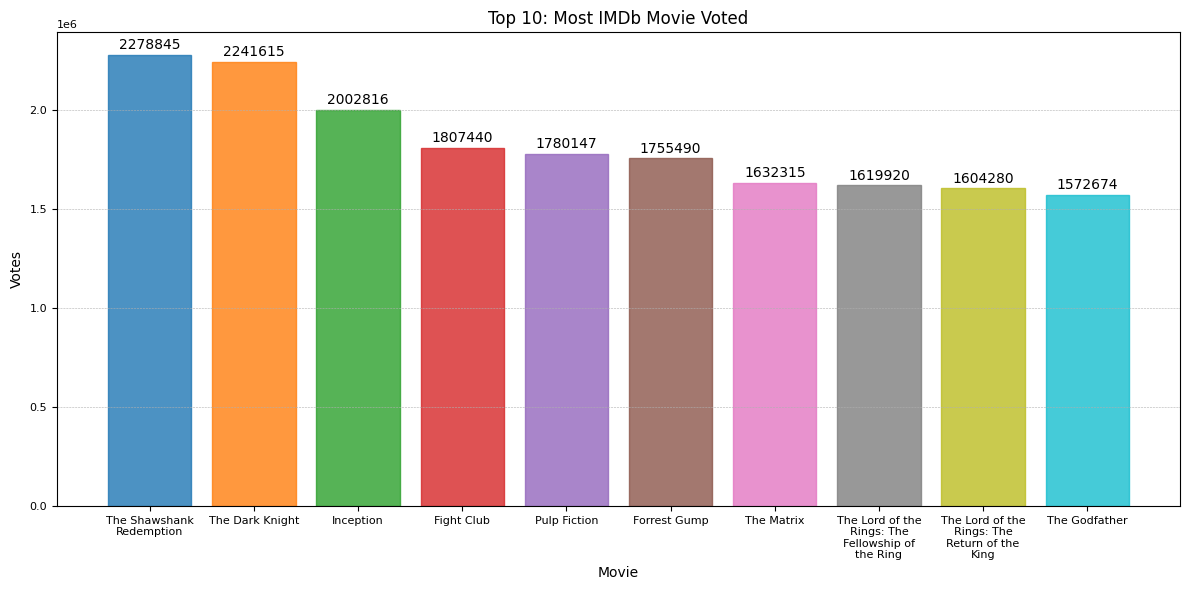

In [5]:
# Movies by IMDb Score
top10_score = df.sort_values('imdb_score', ascending=False).set_index('title')['imdb_score'].head(10)
plot_bar(top10_score, 'Top 10: IMDb Movie Rating', 'Movie', 'IMDb Score', fmt='{:.1f}', ylim=(0, 10))

# Movies by Box Office
top10_box = df.sort_values('world_wide_boxoffice', ascending=False).set_index('title')['world_wide_boxoffice'].head(10)
plot_bar(top10_box, 'Top 10: Worldwide Box Office', 'Movie', 'Box Office (USD)', fmt='${:,.0f}')

# Movies by Popularity
top10_votes = df.sort_values('votes', ascending=False).set_index('title')['votes'].head(10)
plot_bar(top10_votes, 'Top 10: Most IMDb Movie Voted', 'Movie', 'Votes', fmt='{:.0f}')

**Advanced EDA (Actors & Genres)**

Exploding lists for aggregation.

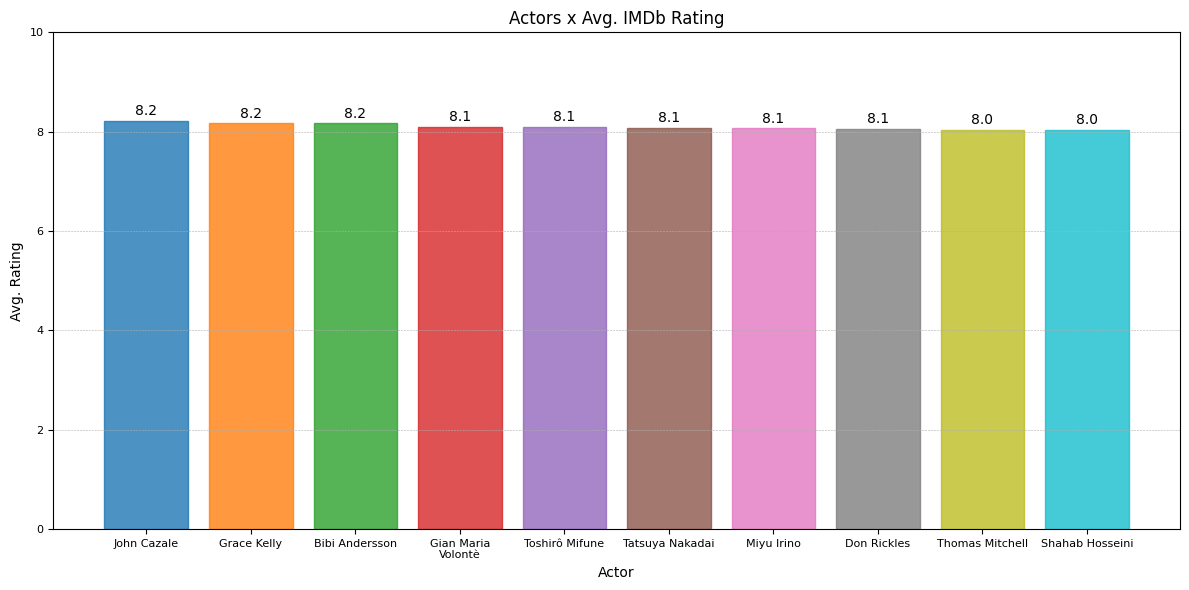

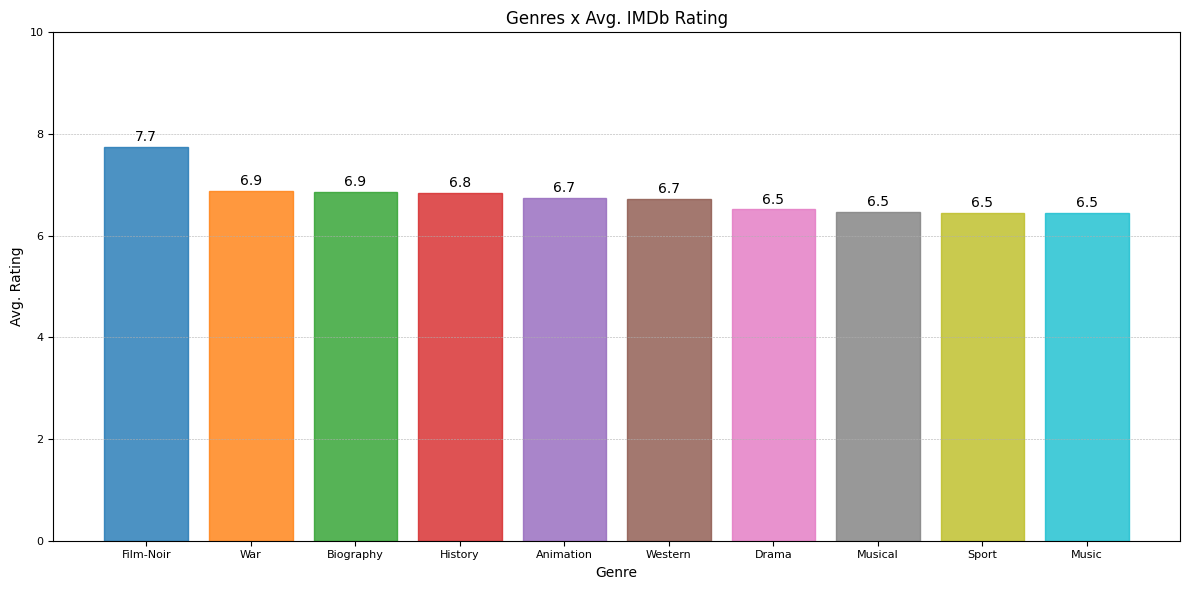

In [6]:
# Actor by Average IMDb Rating
actor_scores = (
    df.explode('actors')
      .groupby('actors')['imdb_score']
      .agg(['count', 'mean'])
      .query('count >= 3')['mean'] # Filter actors with at least 3 films
      .sort_values(ascending=False)
      .head(10)
)
plot_bar(actor_scores, 'Actors x Avg. IMDb Rating', 'Actor', 'Avg. Rating', fmt='{:.1f}', ylim=(0, 10))

# Average IMDb Rating by Genre
genre_scores = (
    df.explode('genres')
      .groupby('genres')['imdb_score']
      .mean()
      .sort_values(ascending=False)
      .head(10)
)
plot_bar(genre_scores, 'Genres x Avg. IMDb Rating', 'Genre', 'Avg. Rating', fmt='{:.1f}', ylim=(0, 10))

**Correlation Heatmap**

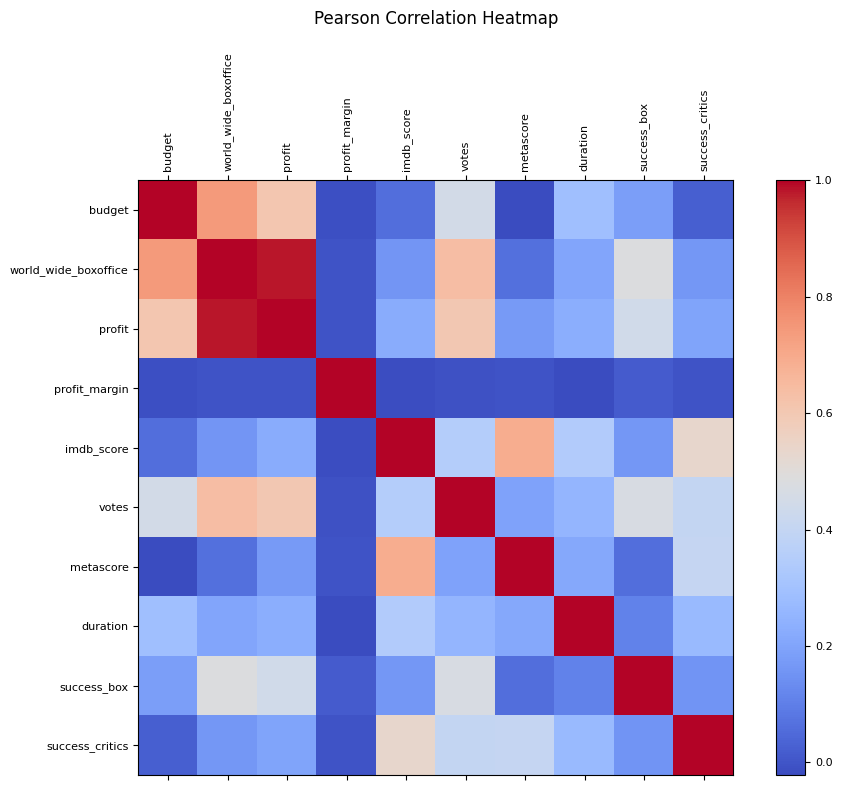

In [7]:
# Define features and targets
features_corr = [
    'budget', 'world_wide_boxoffice', 'profit', 'profit_margin',
    'imdb_score', 'votes', 'metascore', 'duration'
]

# Create temporary targets for correlation check
df_corr = df.copy()
df_corr['success_box'] = (df_corr['profit_margin'] >= 1.0).astype(int)
df_corr['success_critics'] = (df_corr['imdb_score'] >= 7.5).astype(int)

# Compute Pearson correlation matrix
corr_matrix = df_corr[features_corr + ['success_box', 'success_critics']].corr(method='pearson')

# Plot heatmap
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(corr_matrix, interpolation='nearest', cmap='coolwarm')
fig.colorbar(cax)

ticks = np.arange(len(corr_matrix.columns))
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(corr_matrix.columns, rotation=90)
ax.set_yticklabels(corr_matrix.columns)

plt.title("Pearson Correlation Heatmap", pad=20)
plt.tight_layout()
plt.show()

**Simple Linear Regression**
1. Metascore → IMDb Score

Simple LR -> RMSE: 0.69, R2: 0.48


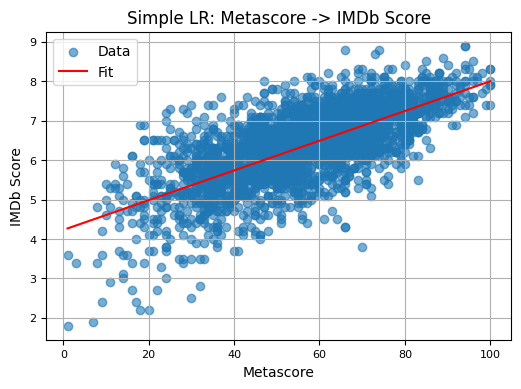

In [8]:
# Prepare Data
df_slr = df.dropna(subset=['metascore','imdb_score'])
X = df_slr[['metascore']].values.reshape(-1, 1)
y = df_slr['imdb_score'].values

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression Modeling
model_slr = LinearRegression()
model_slr.fit(X_train, y_train)

# Metrics
y_pred = model_slr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Simple LR -> RMSE: {rmse:.2f}, R2: {r2:.2f}")

# Plot
plt.figure(figsize=(6,4))
plt.scatter(X_test, y_test, alpha=0.6, label='Data')
x_line = np.array([X.min(), X.max()])[:, None]
plt.plot(x_line, model_slr.predict(x_line), 'r-', label='Fit')
plt.title('Simple LR: Metascore -> IMDb Score')
plt.xlabel('Metascore')
plt.ylabel('IMDb Score')
plt.legend()
plt.grid(True)
plt.show()

**Multiple Linear Regression & 3D Plots**
1. Duration & Year → IMDb Score
2. Release Month & Duration → BoxOffice

Multiple LR: Duration & Year -> IMDb Score
RMSE = 0.86
R2    = 0.20



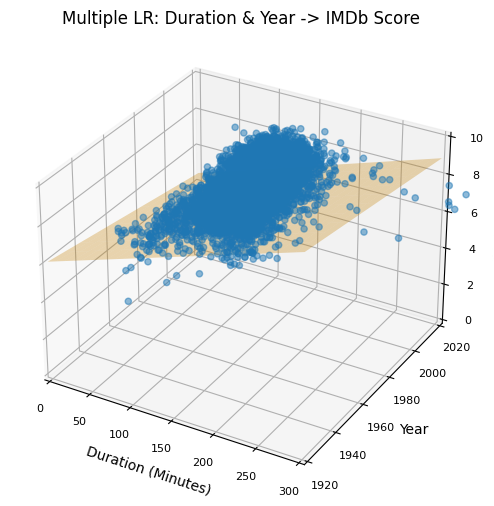

Multiple LR: Release Month & Duration -> BoxOffice
RMSE = 120.16 Millions
R2    = 0.05



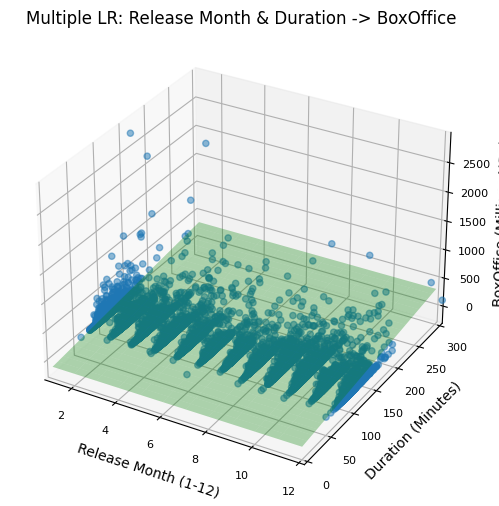

In [9]:
# Duration & Year -> IMDb Score ---
df_r = df.dropna(subset=['imdb_score', 'duration', 'year'])
X_r = df_r[['duration', 'year']].values     
y_r = df_r['imdb_score'].values             

# Train/test split
Xr_tr, Xr_te, yr_tr, yr_te = train_test_split(X_r, y_r, test_size=0.2, random_state=42)

# Fit model
lr_r = LinearRegression().fit(Xr_tr, yr_tr)
yr_pred = lr_r.predict(Xr_te)
rmse_r = np.sqrt(mean_squared_error(yr_te, yr_pred))
r2_r   = r2_score(yr_te, yr_pred)

print("Multiple LR: Duration & Year -> IMDb Score")
print(f"RMSE = {rmse_r:.2f}")
print(f"R2    = {r2_r:.2f}\n")

# 3D Plot 1
dur_range  = np.linspace(0, 300, 30)
year_range = np.arange(1920, 2021, 10)
grid_dur, grid_year = np.meshgrid(dur_range, year_range)
grid_points = np.column_stack((grid_dur.ravel(), grid_year.ravel()))
grid_pred   = lr_r.predict(grid_points).reshape(grid_dur.shape)

fig = plt.figure(figsize=(8,6))
ax  = fig.add_subplot(111, projection='3d')
ax.scatter(X_r[:,0], X_r[:,1], y_r, alpha=0.5, label='Data Points')
ax.plot_surface(grid_dur, grid_year, grid_pred, alpha=0.3, color='orange')
ax.set_xlabel('Duration (Minutes)')
ax.set_xlim(0, 300)
ax.set_ylabel('Year')
ax.set_ylim(1920, 2020)
ax.set_zlabel('IMDb Score')
ax.set_zlim(0, 10)
ax.set_title('Multiple LR: Duration & Year -> IMDb Score')
plt.show()


# Release Month & Duration -> BoxOffice ---
df_b = df.dropna(subset=['world_wide_boxoffice', 'release_month', 'duration'])
X_b = df_b[['release_month', 'duration']].values
y_b = df_b['world_wide_boxoffice'].values / 1e6  # Millions

# Train/test split
Xb_tr, Xb_te, yb_tr, yb_te = train_test_split(X_b, y_b, test_size=0.2, random_state=42)

# Fit model
lr_b    = LinearRegression().fit(Xb_tr, yb_tr)
yb_pred = lr_b.predict(Xb_te)
rmse_b  = np.sqrt(mean_squared_error(yb_te, yb_pred))
r2_b    = r2_score(yb_te, yb_pred)

print("Multiple LR: Release Month & Duration -> BoxOffice")
print(f"RMSE = {rmse_b:.2f} Millions")
print(f"R2    = {r2_b:.2f}\n")

# 3D Plot 2
month_range = np.arange(1, 13)
dur_range2  = np.linspace(0, 300, 30)
grid_month, grid_dur2 = np.meshgrid(month_range, dur_range2)
grid_pts_b  = np.column_stack((grid_month.ravel(), grid_dur2.ravel()))
grid_pred_b = lr_b.predict(grid_pts_b).reshape(grid_dur2.shape)

fig2 = plt.figure(figsize=(8, 6))
ax2  = fig2.add_subplot(111, projection='3d')
ax2.scatter(X_b[:,0], X_b[:,1], y_b, alpha=0.5)
ax2.plot_surface(grid_month, grid_dur2, grid_pred_b, alpha=0.3, color='green')
ax2.set_xlabel('Release Month (1-12)')
ax2.set_xlim(1, 12)
ax2.set_ylabel('Duration (Minutes)')
ax2.set_ylim(0, 300)
ax2.set_zlabel('BoxOffice (Millions USD)')
ax2.set_title('Multiple LR: Release Month & Duration -> BoxOffice')
plt.show()

**Logistic Regression (Classification)**

Target: Success Box Office.

Classification Report:

              precision    recall  f1-score   support

           0      0.975     0.918     0.946      2335
           1      0.586     0.834     0.689       326

    accuracy                          0.908      2661
   macro avg      0.781     0.876     0.817      2661
weighted avg      0.928     0.908     0.914      2661



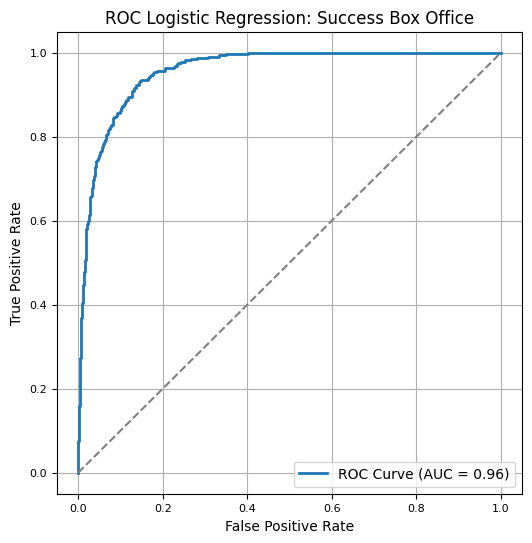

Top Positive Predictors:
                                  feature     coef
                                    votes 2.429872
    production_company_Hollywood Pictures 2.181716
   production_company_Largo Entertainment 2.109210
                     dir_Stuart Hazeldine 2.060950
                         dir_Joseph Ruben 2.050954
       production_company_Pantelion Films 2.037311
                           dir_Jon M. Chu 2.017003
       production_company_Faithstep Films 1.971656
production_company_Golden Harvest Company 1.950061
                 dir_Charles Martin Smith 1.918381

Top Negative Predictors:
              feature      coef
 dir_Alfred Hitchcock -2.401273
     dir_Ridley Scott -1.700264
  dir_Stanley Kubrick -1.664240
     dir_Edgar Wright -1.612990
   dir_John Carpenter -1.566962
  dir_Martin Scorsese -1.514142
     dir_Sidney Lumet -1.440517
    dir_Terry Gilliam -1.400031
dir_Richard Linklater -1.390270
      dir_David Lynch -1.233137


In [10]:
# Define Success: Profit Margin >= 1.0 AND Profit > 50M
df_log = df.copy()
df_log['success_box'] = ((df_log['profit_margin'] >= 1.0) & (df_log['profit'] > 50_000_000)).astype(int)

# Numeric features
num_feats = ['duration', 'imdb_score', 'votes', 'metascore']
X_num = df_log[num_feats]

# Pipeline for numerics
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
X_num_proc = num_pipeline.fit_transform(X_num)

# MultiLabelBinarizer for genres and directors
mlb_genres = MultiLabelBinarizer()
genres_ohe = mlb_genres.fit_transform(df_log['genres'])
genre_cols = ['genre_' + g for g in mlb_genres.classes_]

mlb_dirs = MultiLabelBinarizer()
dirs_ohe = mlb_dirs.fit_transform(df_log['directors'])
dir_cols = ['dir_' + d for d in mlb_dirs.classes_]

# One-hot for single-valued categoricals
cat_cols = ['production_company', 'release_month', 'country', 'language']
# Ensure all categorical columns are of object type before filling with 'Unknown'
for col in cat_cols:
    df_log[col] = df_log[col].astype('object')
df_log[cat_cols] = df_log[cat_cols].fillna('Unknown')
cat_single = pd.get_dummies(df_log[cat_cols], drop_first=True)

# Assemble matrix
X = np.hstack([X_num_proc, genres_ohe, dirs_ohe, cat_single.values])
feature_names = num_feats + genre_cols + dir_cols + list(cat_single.columns)
y = df_log['success_box'].values

# Train/test split stratified
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Logistic Regression Modeling 
clf = LogisticRegression(max_iter=1000, class_weight='balanced')
clf.fit(X_tr, y_tr)

# Evaluation
y_pred = clf.predict(X_te)
y_proba = clf.predict_proba(X_te)[:, 1]

print("Classification Report:\n")
print(classification_report(y_te, y_pred, digits=3))

# ROC Curve
fpr, tpr, _ = roc_curve(y_te, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.title('ROC Logistic Regression: Success Box Office')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend(loc='lower right')
plt.show()

# Top Predictors
coef = clf.coef_[0]
coef_df = pd.DataFrame({'feature': feature_names, 'coef': coef})
coef_df['abs_coef'] = coef_df['coef'].abs()
top_pos = coef_df.nlargest(10, 'coef')[['feature','coef']]
top_neg = coef_df.nsmallest(10, 'coef')[['feature','coef']]

print("Top Positive Predictors:")
print(top_pos.to_string(index=False))
print("\nTop Negative Predictors:")
print(top_neg.to_string(index=False))

**Linear SVC (Classification)**

Target: IMDb Rating Classes (Bad/Mid/Good)

Classification Report:

              precision    recall  f1-score   support

         Bad      0.290     0.149     0.197       241
         Mid      0.743     0.810     0.775      1688
        Good      0.636     0.605     0.620       732

    accuracy                          0.694      2661
   macro avg      0.556     0.521     0.531      2661
weighted avg      0.672     0.694     0.680      2661



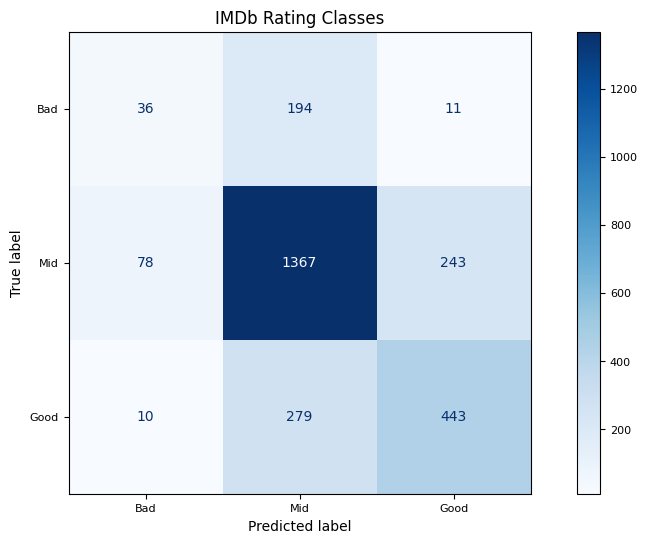

In [19]:
def imdb_label(score):
    if score <= 5: return 0  # Bad 
    elif score < 7: return 1  # Mid
    else: return 2  # Good

df_svc = df.dropna(subset=['imdb_score']).copy()
df_svc['rating_class'] = df_svc['imdb_score'].apply(imdb_label)

# Reuse the numeric features from previous block
# Ensure any pandas.NA or non-numeric values are coerced to np.nan so SimpleImputer can handle them
X_num_df = df_svc[['duration', 'votes', 'budget', 'profit_margin']].copy()
X_num_df = X_num_df.apply(pd.to_numeric, errors='coerce')  # convert NAType -> np.nan
X_num_svc = num_pipeline.fit_transform(X_num_df)

# Re-generate OHE for this subset (to ensure index alignment)   
genres_ohe_svc = mlb_genres.transform(df_svc['genres'])
dirs_ohe_svc = mlb_dirs.transform(df_svc['directors'])

# Ensure categorical columns are converted to object BEFORE filling with strings
# (filling first can raise TypeError on integer extension dtypes like Int8)
df_svc[cat_cols] = df_svc[cat_cols].astype('object')
cat_single_svc = pd.get_dummies(df_svc[cat_cols].fillna('Unknown'), drop_first=True)

# Assemble feature matrix
X_svc = np.hstack([
    X_num_svc,
    genres_ohe_svc,
    dirs_ohe_svc,
    cat_single_svc.values
])
y_svc = df_svc['rating_class'].values

# Train/Test split
X_tr_svc, X_te_svc, y_tr_svc, y_te_svc = train_test_split(
    X_svc, y_svc, test_size=0.2, random_state=42, stratify=y_svc
)

# LinearSVC
svc = LinearSVC(C=1.0, class_weight='balanced', max_iter=10000, dual=True)
svc.fit(X_tr_svc, y_tr_svc)

# Metrics
y_pred_svc = svc.predict(X_te_svc)
print("Classification Report:\n")
print(classification_report(y_te_svc, y_pred_svc, target_names=['Bad','Mid','Good'], digits=3))

# Confusion Matrix
cm = confusion_matrix(y_te_svc, y_pred_svc)
disp = ConfusionMatrixDisplay(cm, display_labels=['Bad','Mid','Good'])
disp.plot(cmap='Blues')
plt.title('IMDb Rating Classes')
plt.show()

**Time Series Analysis**

Re-constructs time index for seasonal/pandemic analysis.

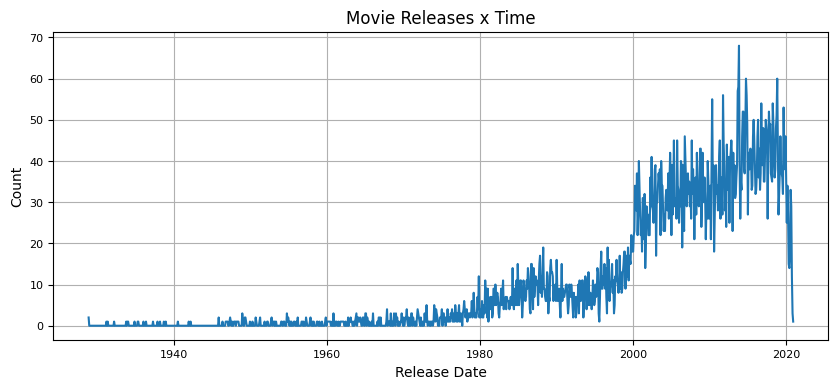

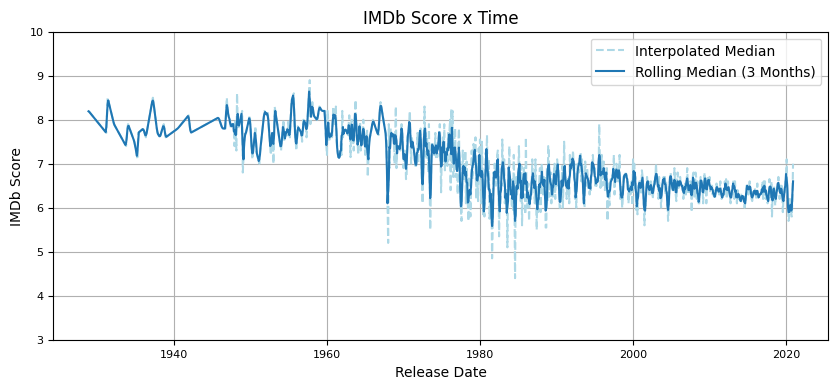

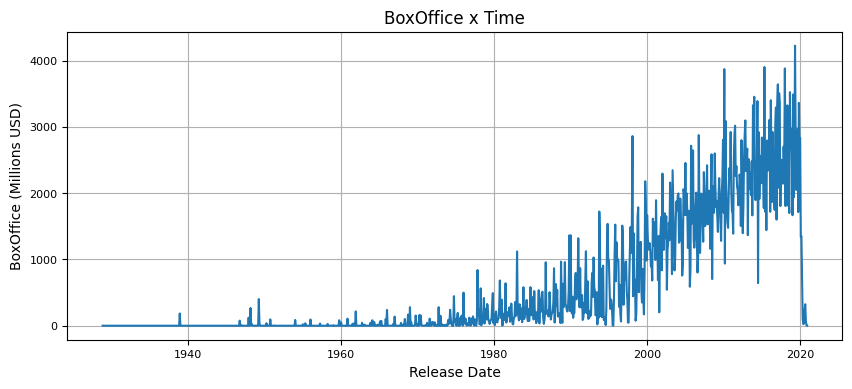

Time Series Insights:
Pandemic impact: Avg monthly boxoffice dropped from 2748.7M (2019) to 385.1M (2020).
Decrease of 86%.


In [13]:
# Prepare Time Series Data
df_ts = df.dropna(subset=['year', 'release_month', 'imdb_score', 'world_wide_boxoffice']).copy()
df_ts = df_ts.set_index('release_date').sort_index()

# Resample monthly and compute metrics
count = df_ts['id'].resample('M').count() 
median_score = df_ts['imdb_score'].resample('M').median()
median_interp = median_score.interpolate() 
median_smooth = median_interp.rolling(3, min_periods=1, center=True).mean() 
total_box = df_ts['world_wide_boxoffice'].resample('M').sum() / 1e6  # Millions

# 1. Monthly Number of Releases
plt.figure(figsize=(10, 4))
plt.plot(count.index, count.values)
plt.title('Movie Releases x Time')
plt.xlabel('Release Date')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# 2. IMDb Score Trends
plt.figure(figsize=(10, 4))
plt.plot(median_interp.index, median_interp.values, linestyle='--', color='lightblue', label='Interpolated Median')
plt.plot(median_smooth.index, median_smooth.values, linestyle='-', label='Rolling Median (3 Months)')
plt.title('IMDb Score x Time')
plt.xlabel('Release Date')
plt.ylabel('IMDb Score')
plt.ylim(3, 10)
plt.legend()
plt.grid(True)
plt.show()

# 3. Box Office Trends
plt.figure(figsize=(10, 4))
plt.plot(total_box.index, total_box.values)
plt.title('BoxOffice x Time')
plt.xlabel('Release Date')
plt.ylabel('BoxOffice (Millions USD)')
plt.grid(True)
plt.show()

# 4. Insights (Pandemic & Seasonality)
box_2019 = df_ts.loc['2019', 'world_wide_boxoffice'].resample('M').sum().mean() / 1e6
box_2020 = df_ts.loc['2020', 'world_wide_boxoffice'].resample('M').sum().mean() / 1e6
pct_drop = (box_2019 - box_2020) / box_2019 * 100

print("Time Series Insights:")
print(f"Pandemic impact: Avg monthly boxoffice dropped from {box_2019:.1f}M (2019) to {box_2020:.1f}M (2020).")
print(f"Decrease of {pct_drop:.0f}%.")

**Deep Learning (Dual Task)**

Classification (Success) & Regression (Score)

In [14]:
# Preprocess specific for DL (using all data logic from start)
# We reuse the main 'df' but ensure types are float32 for TensorFlow
df_dl = df.dropna(subset=[
    'duration','votes','metascore','budget',
    'production_company','release_month','country','language',
    'profit','profit_margin','imdb_score'
]).copy()

# Targets
df_dl['success_box'] = ((df_dl['profit_margin'] >= 1.0) & (df_dl['profit'] > 50_000_000)).astype(int)

# Numeric Features
num_feats_dl = ['duration','votes','metascore','budget']
X_num_dl = SimpleImputer(strategy='median').fit_transform(df_dl[num_feats_dl])
X_num_dl = StandardScaler().fit_transform(X_num_dl)

# Multi-label Features
mlb_cols = ['genres','directors','writers','actors']
X_mlb_list = []
for col in mlb_cols:
    mlb = MultiLabelBinarizer()
    X_mlb_list.append(mlb.fit_transform(df_dl[col]))
X_mlb_dl = np.hstack(X_mlb_list)

# Single Categorical Features
cat_cols = ['production_company','release_month','country','language']
df_dl[cat_cols] = df_dl[cat_cols].fillna('Unknown')
X_cat_dl = pd.get_dummies(df_dl[cat_cols], drop_first=True).values

# Combine Features
X_dl = np.hstack([X_num_dl, X_mlb_dl, X_cat_dl]).astype(np.float32)

# Classification Model 
y_box_dl = df_dl['success_box'].astype(np.float32).values
X_tr, X_te, y_tr, y_te = train_test_split(X_dl, y_box_dl, test_size=0.2, random_state=42, stratify=y_box_dl)

model_clf = models.Sequential([
    layers.Input(shape=(X_dl.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])
model_clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

history_clf = model_clf.fit(
    X_tr, y_tr, validation_split=0.2, epochs=100, batch_size=64,
    callbacks=[EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True)],
    verbose=0 # Silent training
)
print("DL Classification Training Complete.")

# Regression Model
y_score_dl = df_dl['imdb_score'].astype(np.float32).values
X_tr_r, X_te_r, y_tr_r, y_te_r = train_test_split(X_dl, y_score_dl, test_size=0.2, random_state=42)

model_reg = models.Sequential([
    layers.Input(shape=(X_dl.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='linear')
])
model_reg.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae'])

history_reg = model_reg.fit(
    X_tr_r, y_tr_r, validation_split=0.2, epochs=100, batch_size=64,
    callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)],
    verbose=0 # Silent training
)
print("DL Regression Training Complete.")

DL Classification Training Complete.
DL Regression Training Complete.


**Deep Learning Results & Plots**

Visualizing performance for both DL models.

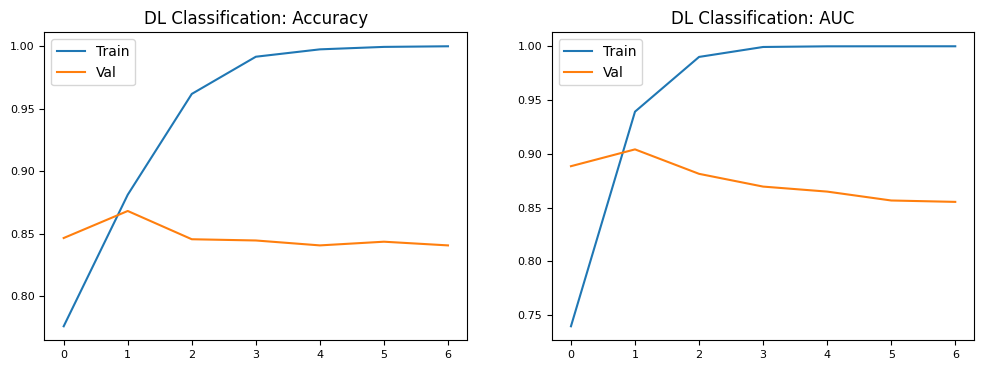

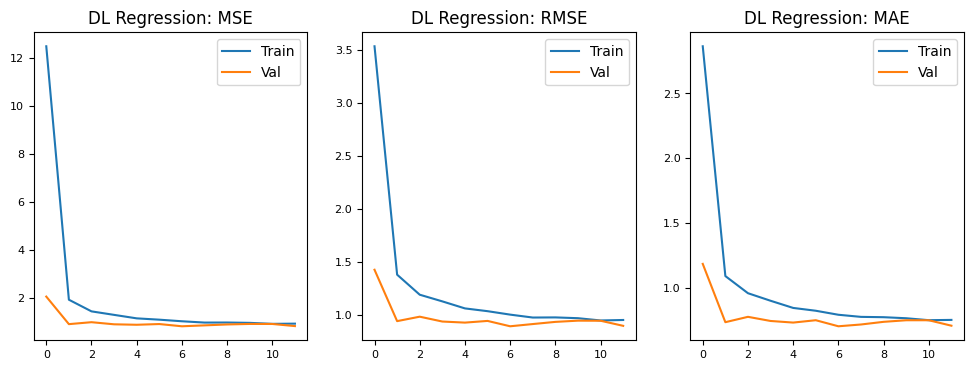

Final Test AUC: 0.8791
Final Test RMSE: 0.8789


In [15]:
# 1. Classification Plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_clf.history['accuracy'], label='Train')
plt.plot(history_clf.history['val_accuracy'], label='Val')
plt.title('DL Classification: Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_clf.history['auc'], label='Train')
plt.plot(history_clf.history['val_auc'], label='Val')
plt.title('DL Classification: AUC')
plt.legend()
plt.show()

# 2. Regression Plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history_reg.history['loss'], label='Train')
plt.plot(history_reg.history['val_loss'], label='Val')
plt.title('DL Regression: MSE')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history_reg.history['rmse'], label='Train')
plt.plot(history_reg.history['val_rmse'], label='Val')
plt.title('DL Regression: RMSE')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history_reg.history['mae'], label='Train')
plt.plot(history_reg.history['val_mae'], label='Val')
plt.title('DL Regression: MAE')
plt.legend()
plt.show()

# Final Evaluation
results_clf = model_clf.evaluate(X_te, y_te, verbose=0)
print(f"Final Test AUC: {results_clf[2]:.4f}")

results_reg = model_reg.evaluate(X_te_r, y_te_r, verbose=0)
print(f"Final Test RMSE: {results_reg[1]:.4f}")